In [228]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.sparse.linalg import cg as scipy_cg

from jlinops import _CustomLinearOperator
import jlinops

# FCG implementation

In [235]:
def cg(A, b, x0=None, atol=1e-5, maxiter=None, residual_method="approximate", x_true=None):
    """Implements preconditioned conjugate gradient method.
    """

    assert residual_method in ["exact", "approximate"], "invalid residual_method parameter!"

    # Get shape
    n = A.shape[0]
    if maxiter is None: maxiter = n

    # Initialization
    if x0 is None:
        x = np.zeros(n)
    else:
        x = x0

    # Setup
    r_prev = b - (A @ x)
    p = r_prev.copy()
    n_its = 0
    residual_norms = [ np.linalg.norm(r_prev) ]
    if x_true is not None:
        x_err = np.linalg.norm(x - x_true)
        x_errs = x_err

    # Should we terminate before starting?
    if np.linalg.norm(r_prev) < atol:
        pass

    else:

        for i in range(maxiter):
            Ap = A @ p
            alpha = np.dot(r_prev, r_prev)/np.dot(p, Ap)
            x += alpha*p
            r_next = r_prev - alpha*Ap
            n_its += 1

            if residual_method == "approximate":
                residual = r_next
            elif residual_method == "exact":
                residual = b - (A @ x)
            else:
                raise NotImplementedError
            residual_norms.append( np.linalg.norm(residual) )

            if np.linalg.norm(residual) < atol: break

            beta = np.dot(r_next, r_next)/np.dot(r_prev, r_prev)
            p = r_next + beta*p
            r_prev = r_next.copy()

            # Track err?
            if x_true is not None:
                x_err = np.linalg.norm(x - x_true)
                x_errs.append(x_err)


    data = {
        "x": x,
        "n_its": n_its,
        "residual_norms": np.asarray(residual_norms),
    }

    if x_true is not None:
        data["x_errs"] = np.asarray(x_errs)

    return data


In [236]:
def ipcg(A, b, M, x0=None, rtol=1e-3, eta=1.0, e_norm=1.0, maxiter=None, Mcond=None, beta_formula="polyak-ribiere", residual_method="exact", x_true=None):
    """Represents inexact preconditioned CG method.

    e_norm: expected value of the vector e.
    """

    assert beta_formula in ["polyak-ribiere", "fletcher-reeves"], "invalid beta_formula parameter!"
    assert residual_method in ["exact", "approximate"], "invalid residual_method parameter!"

    # Get shape
    n = A.shape[0]
    if maxiter is None: maxiter = n

    # Initialization
    if x0 is None:
        x = np.zeros(n)
    else:
        x = x0

    # eta
    eta_tilde = eta/np.sqrt(Mcond)

    # bnorm
    bnorm = np.linalg.norm(b)

    # Setup
    r_prev = np.zeros(n)
    p = r_prev.copy()
    r_next = b - (A @ x)
    beta = 0
    residual_norms = [np.linalg.norm(r_next)]

    if x_true is not None:
        x_err = np.linalg.norm(x - x_true)
        x_errs = [ x_err ] 

    n_inner_its = 0
    n_outer_its = 0

    # Should we terminate before starting?
    if np.linalg.norm(r_next)/bnorm < rtol:
        pass

    else:

        for i in range(maxiter):
            
            cgdata = cg(M, r_next, atol=eta_tilde*np.linalg.norm(r_next) )
            n_inner_its += cgdata["n_its"]
            z_next = cgdata["x"]

            if i > 1:
                if beta_formula == "polyak-ribiere":
                    beta = np.dot( z_next, r_next - r_prev ) / np.dot(z_prev, r_prev)
                elif beta_formula == "fletcher-reeves":
                    beta = np.dot( z_next, r_next ) / np.dot( z_prev, r_prev )
                else:
                    raise NotImplementedError

            p = z_next + beta*p
            Ap = A @ p
            alpha = np.dot(z_next, r_next)/(np.dot(p, Ap))
            r_prev = r_next.copy()
            r_next -= alpha * Ap
            x += alpha*p
            z_prev = z_next.copy()

            # Store residual
            if residual_method == "approximate":
                residual_norms.append( np.linalg.norm( r_prev ) )
            elif residual_method == "exact":
                residual_norms.append( np.linalg.norm( b - (A @ x) ) )
            else:
                raise NotImplementedError
            
            # Break?
            if np.linalg.norm(r_prev)/bnorm < rtol:
                break
            n_outer_its += 1
            
            # Track x_err?
            if x_true is not None:
                x_err = np.linalg.norm(x - x_true)
                x_errs.append(x_err)

    data = {
        "x": x,
        "residual_norms": np.asarray(residual_norms),
        "n_inner_its": n_inner_its,
        "n_outer_its": n_outer_its,
    }
    if x_true is not None:
        data["x_errs"] = np.asarray(x_errs)
    
    return data
    

In [237]:
def fcg(A, b, Minv, rtol=1e-4, x0=None, maxiter=None, residual_method="exact", x_true=None):
    """Implements the FCG method.
    """

    assert residual_method in ["exact", "approximate"], "invalid residual_method parameter!"

    n = A.shape[0]
    if maxiter is None: maxiter = n
    bnorm = np.linalg.norm(b)

    # Initialization
    if x0 is None:
        x = np.zeros(n)
    else:
        x = x0

    # Initial residual
    r = b - A @ x
    residual_norms = [ np.linalg.norm(r) ]

    if x_true is not None:
        x_err = np.linalg.norm(x - x_true)
        x_errs = [ x_err ] 

    n_basis_vectors = 0
    n_iters = 0
    lucky_breakdown = False
    converged = False

    # Should we do anything at all?
    if np.linalg.norm(r)/bnorm < rtol:
        p = z.copy()
        p = p/np.linalg.norm(p)
        P = p[:,None]
        Ap = None
        converged = True
        pass

    else:
        
        for i in range(maxiter):

            # Apply preconditioner and store result
            z = Minv @ r
    
            # Create new search direction
            if i == 0:
                p = z.copy()
                p = p/np.linalg.norm(p)
                P = p[:,None]
                n_basis_vectors += 1
            else:
                p = z.copy()
                for j in range(n_basis_vectors):
                    coeff = np.dot( z, AP[:,j]  ) / np.dot( P[:,j], AP[:,j] )
                    p -= coeff*P[:,j]

                if np.linalg.norm(p) < 1e-15:
                    lucky_breakdown = True
                    break
                
                p = p/np.linalg.norm(p)
                P = np.hstack([P, p[:,None]])
                n_basis_vectors += 1

            Ap = A @ p
            if i == 0:
                AP = Ap[:,None]
            else:
                AP = np.hstack([ AP, Ap[:,None] ])

            coeff = np.dot(p, r) / np.dot(p, Ap)
            x += coeff*p
            r -= coeff*Ap 
            residual_norms.append(np.linalg.norm(r))
            n_iters += 1

            # Track x_err?
            if x_true is not None:
                x_err = np.linalg.norm(x - x_true)
                x_errs.append(x_err)

            # Should we stop?
            if np.linalg.norm(r)/bnorm < rtol:
                converged = True
                break

    data = {
        "x": x,
        "P": P,
        "AP": AP,
        "n_iters": n_iters,
        "lucky_breakdown": lucky_breakdown,
        "converged": converged,
        "residual_norms": np.asarray(residual_norms),
    }
    if x_true is not None:
        data["x_errs"] = np.asarray(x_errs)

    return data


# Test it out

In [238]:
n = 100
R, _ = jlinops.first_order_derivative_1d(n, boundary="zero")
R = R.toarray()

np.random.seed(1)
w = np.random.uniform(low=5, high=45, size=R.shape[0])

Amat = R.T @ np.diag(w) @ R
A = jlinops.MatrixLinearOperator(Amat)
Mmat = R.T @ R
M = jlinops.MatrixLinearOperator(Mmat)
Mcond = np.linalg.cond(Mmat)
Minv_mat = np.linalg.inv(Mmat)
Minv = jlinops.MatrixLinearOperator(Minv_mat)
b = np.random.normal(size=n)
x_true = np.linalg.solve(Amat, b)

# Make class for representing linear operator with error
class ArtificialErrorSPDLinearOperator(_CustomLinearOperator):

    def __init__(self, A, delta, method="inner"):
        
        self.Atrue = A
        self.delta = delta
        shape = A.shape

        assert method in ["inner", "outer"], "invalid method choice!"
        
        if method == "outer":
            _matvec = lambda x: self.Atrue.matvec(x) + delta*np.random.normal(size=shape[0])
        elif method == "inner":
            _matvec = lambda x: self.Atrue.matvec( x + delta*np.random.normal(size=shape[0]) )
        else:
            raise NotImplementedError

        super().__init__(shape, _matvec, _matvec, device=A.device)

In [255]:
Minv_approx = jlinops.CGInverseOperator(M, tol=1e-2)
x_true = np.linalg.solve(Amat, b)

In [256]:
np.linalg.cond(Amat)

30434.928333456748

In [257]:
data = fcg(A, b, Minv_approx, x0=None, rtol=1e-6, maxiter=100, x_true=x_true)
data["converged"]

False

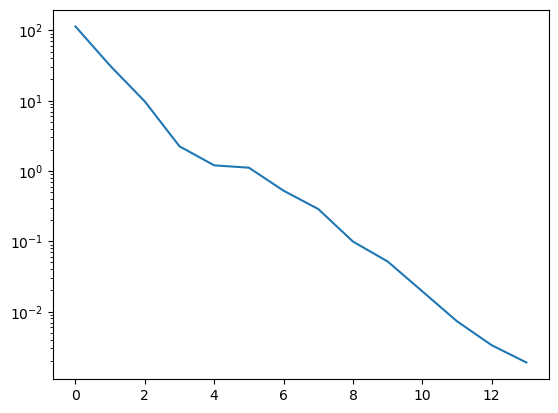

In [258]:
plt.semilogy(data["x_errs"])
plt.show()

In [249]:
# data2 = ipcg(A, b, Minv_approx, x0=None, rtol=1e-6, eta=1e-4, Mcond=np.linalg.cond(Mmat), maxiter=100, x_true=x_true)

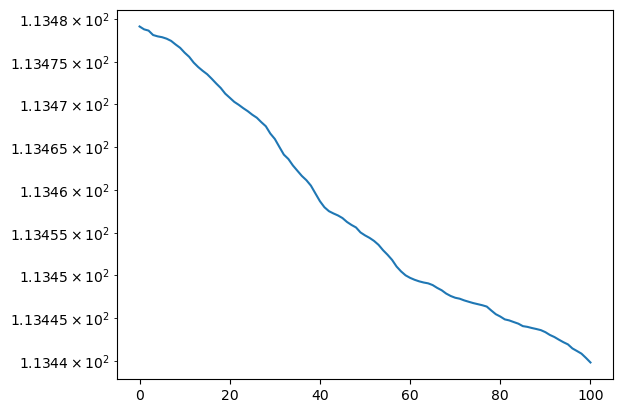

In [247]:
plt.semilogy(data2["x_errs"])
plt.show()

In [190]:
data.keys()

dict_keys(['x', 'P', 'AP', 'n_iters', 'lucky_breakdown', 'x_errs'])

In [191]:
data["n_iters"]

23

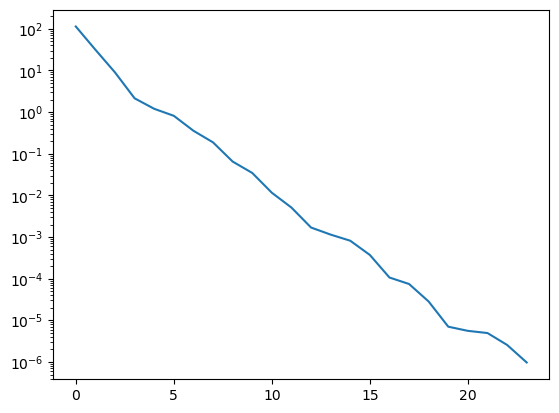

In [192]:
plt.semilogy(data["x_errs"])
plt.show()

In [150]:
np.linalg.norm( data["x"] - x_true ) 

nan

In [152]:
data.keys()

dict_keys(['x', 'P', 'AP', 'x_errs'])

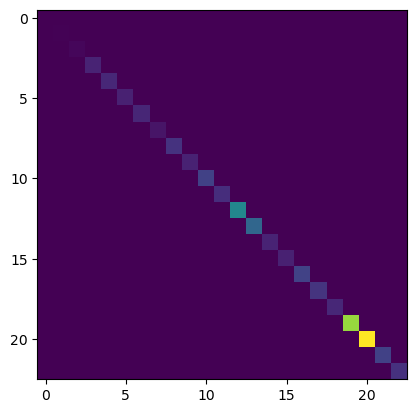

In [193]:
plt.imshow( data["P"][:,:].T @ A @ data["P"][:,:] )
plt.show()